In [1]:
import os

import numpy as np
import random

import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow_io as tfio
from tensorflow.keras import layers, models, initializers, optimizers
from tensorflow.keras.utils import plot_model

import matplotlib.pyplot as plt


2024-07-25 12:37:56.892897: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-25 12:37:56.892996: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-25 12:37:57.041062: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
img_folder = "/kaggle/input/mm-whs/MM WHS 128/img"
mask_folder = "/kaggle/input/mm-whs/MM WHS 128/mask_corrected"


In [3]:
img_files = [f for f in os.listdir(img_folder) if f.endswith('.tif')]

batch_size = 16
# Preprocess images and masks
def preprocess(img_path, mask_path):
    img = tf.io.read_file(img_path)
    img = tfio.experimental.image.decode_tiff(img, index=0)  # Ensure correct decoding of TIFF images
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [128, 128])
    
    mask = tf.io.read_file(mask_path)
    mask = tfio.experimental.image.decode_tiff(mask, index=0)  # Ensure correct decoding of TIFF images
    mask = tf.image.convert_image_dtype(mask, tf.float32)
    mask = tf.image.resize(mask, [128, 128])
    mask = tf.where(mask > 0, 1.0, 0.0)  # Binarize mask
    
    return img, mask

# Function to load dataset
def load_dataset(img_folder, mask_folder, img_files, batch_size=batch_size):
    img_paths = [os.path.join(img_folder, f) for f in img_files]
    mask_paths = [os.path.join(mask_folder, f.replace('image', 'label')) for f in img_files]
    
    dataset = tf.data.Dataset.from_tensor_slices((img_paths, mask_paths))
    dataset = dataset.map(lambda img, mask: preprocess(img, mask), num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    
    return dataset

# Split dataset into training and validation sets
random.shuffle(img_files)
split_idx = int(len(img_files) * 0.8)
train_files = img_files[:split_idx]
val_files = img_files[split_idx:]

train_dataset = load_dataset(img_folder, mask_folder, train_files)
val_dataset = load_dataset(img_folder, mask_folder, val_files)


# UNET RAW MODEL 

In [4]:
n = 4
def unet_model(input_size=(128, 128, 1)):
    inputs = layers.Input(input_size)
    
    # Encoder
    conv1 = layers.Conv2D(n*4, 3, activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(n*4, 3, activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = layers.Conv2D(n*8, 3, activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(n*8, 3, activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = layers.Conv2D(n*16, 3, activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(n*16, 3, activation='relu', padding='same')(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = layers.Conv2D(n*32, 3, activation='relu', padding='same')(pool3)
    conv4 = layers.Conv2D(n*32, 3, activation='relu', padding='same')(conv4)
    pool4 = layers.MaxPooling2D(pool_size=(2, 2))(conv4)
    
    # Bridge
    conv5 = layers.Conv2D(n*64, 3, activation='relu', padding='same')(pool4)
    conv5 = layers.Conv2D(n*64, 3, activation='relu', padding='same')(conv5)
    
    # Decoder
    up6 = layers.Conv2DTranspose(n*32, 2, strides=(2, 2), padding='same')(conv5)
    merge6 = layers.concatenate([conv4, up6], axis=3)
    conv6 = layers.Conv2D(n*32, 3, activation='relu', padding='same')(merge6)
    conv6 = layers.Conv2D(n*32, 3, activation='relu', padding='same')(conv6)
    
    up7 = layers.Conv2DTranspose(n*16, 2, strides=(2, 2), padding='same')(conv6)
    merge7 = layers.concatenate([conv3, up7], axis=3)
    conv7 = layers.Conv2D(n*16, 3, activation='relu', padding='same')(merge7)
    conv7 = layers.Conv2D(n*16, 3, activation='relu', padding='same')(conv7)
    
    up8 = layers.Conv2DTranspose(n*8, 2, strides=(2, 2), padding='same')(conv7)
    merge8 = layers.concatenate([conv2, up8], axis=3)
    conv8 = layers.Conv2D(n*8, 3, activation='relu', padding='same')(merge8)
    conv8 = layers.Conv2D(n*8, 3, activation='relu', padding='same')(conv8)
    
    up9 = layers.Conv2DTranspose(n*4, 2, strides=(2, 2), padding='same')(conv8)
    merge9 = layers.concatenate([conv1, up9], axis=3)
    conv9 = layers.Conv2D(n*4, 3, activation='relu', padding='same')(merge9)
    conv9 = layers.Conv2D(n*4, 3, activation='relu', padding='same')(conv9)
    
    outputs = layers.Conv2D(1, 1, activation='sigmoid')(conv9)
    
    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model

model = unet_model()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        160 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      2,320 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │      9,248 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │     36,928 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │    147,584 │ conv2d_6[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 8, 8, 128) │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 8, 8, 256) │    295,168 │ max_pooling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 8, 8, 256) │    590,080 │ conv2d_8[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 16, 16,    │    131,200 │ conv2d_9[0][0]    │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 16, 16,    │          0 │ conv2d_7[0][0],   │
│ (Concatenate)       │ 256)              │            │ conv2d_transpose… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 1,940,817 (7.40 MB)

 Trainable params: 1,940,817 (7.40 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
# Set the number of epochs
num_epochs = 20

# Train the model
# history = model.fit(train_dataset, epochs=num_epochs, validation_data=val_dataset)


# UNET MODEL (He Initialization)

In [6]:
def iou_metric(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred) - intersection
    iou = intersection / (union + K.epsilon())
    return iou

def dice_coefficient(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    intersection = K.sum(y_true * y_pred)
    return (2. * intersection + K.epsilon()) / (K.sum(y_true) + K.sum(y_pred) + K.epsilon())


In [7]:
def simpler_unet_model(input_size=(128, 128, 1)):
    inputs = layers.Input(input_size)
    
    # Encoder
    conv1 = layers.Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=initializers.HeNormal())(inputs)
    conv1 = layers.BatchNormalization()(conv1)
    conv1 = layers.Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=initializers.HeNormal())(conv1)
    conv1 = layers.BatchNormalization()(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)
    pool1 = layers.Dropout(0.25)(pool1)
    
    conv2 = layers.Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=initializers.HeNormal())(pool1)
    conv2 = layers.BatchNormalization()(conv2)
    conv2 = layers.Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=initializers.HeNormal())(conv2)
    conv2 = layers.BatchNormalization()(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)
    pool2 = layers.Dropout(0.25)(pool2)
    
    conv3 = layers.Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=initializers.HeNormal())(pool2)
    conv3 = layers.BatchNormalization()(conv3)
    conv3 = layers.Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=initializers.HeNormal())(conv3)
    conv3 = layers.BatchNormalization()(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)
    pool3 = layers.Dropout(0.25)(pool3)
    
    conv4 = layers.Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=initializers.HeNormal())(pool3)
    conv4 = layers.BatchNormalization()(conv4)
    conv4 = layers.Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=initializers.HeNormal())(conv4)
    conv4 = layers.BatchNormalization()(conv4)
    pool4 = layers.MaxPooling2D(pool_size=(2, 2))(conv4)
    pool4 = layers.Dropout(0.25)(pool4)
    
    # Bridge
    conv5 = layers.Conv2D(512, 3, activation='relu', padding='same', kernel_initializer=initializers.HeNormal())(pool4)
    conv5 = layers.BatchNormalization()(conv5)
    conv5 = layers.Conv2D(512, 3, activation='relu', padding='same', kernel_initializer=initializers.HeNormal())(conv5)
    conv5 = layers.BatchNormalization()(conv5)
    
    # Decoder
    up6 = layers.Conv2DTranspose(256, 2, strides=(2, 2), padding='same', kernel_initializer=initializers.HeNormal())(conv5)
    merge6 = layers.concatenate([conv4, up6], axis=3)
    conv6 = layers.Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=initializers.HeNormal())(merge6)
    conv6 = layers.BatchNormalization()(conv6)
    conv6 = layers.Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=initializers.HeNormal())(conv6)
    conv6 = layers.BatchNormalization()(conv6)
    
    up7 = layers.Conv2DTranspose(128, 2, strides=(2, 2), padding='same', kernel_initializer=initializers.HeNormal())(conv6)
    merge7 = layers.concatenate([conv3, up7], axis=3)
    conv7 = layers.Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=initializers.HeNormal())(merge7)
    conv7 = layers.BatchNormalization()(conv7)
    conv7 = layers.Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=initializers.HeNormal())(conv7)
    conv7 = layers.BatchNormalization()(conv7)
    
    up8 = layers.Conv2DTranspose(64, 2, strides=(2, 2), padding='same', kernel_initializer=initializers.HeNormal())(conv7)
    merge8 = layers.concatenate([conv2, up8], axis=3)
    conv8 = layers.Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=initializers.HeNormal())(merge8)
    conv8 = layers.BatchNormalization()(conv8)
    conv8 = layers.Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=initializers.HeNormal())(conv8)
    conv8 = layers.BatchNormalization()(conv8)
    
    up9 = layers.Conv2DTranspose(32, 2, strides=(2, 2), padding='same', kernel_initializer=initializers.HeNormal())(conv8)
    merge9 = layers.concatenate([conv1, up9], axis=3)
    conv9 = layers.Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=initializers.HeNormal())(merge9)
    conv9 = layers.BatchNormalization()(conv9)
    conv9 = layers.Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=initializers.HeNormal())(conv9)
    conv9 = layers.BatchNormalization()(conv9)
    
    outputs = layers.Conv2D(1, 1, activation='sigmoid')(conv9)
    
    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model

model = simpler_unet_model()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss = 'binary_crossentropy',
#               metrics=['accuracy'])
              metrics=['accuracy', iou_metric, dice_coefficient])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 128, 128,  │        320 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │        128 │ conv2d_19[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 128, 128,  │      9,248 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_20[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64, 64,    │          0 │ max_pooling2d_4[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 64, 64,    │     18,496 │ dropout[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_21[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 64, 64,    │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_22[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 32, 32,    │          0 │ max_pooling2d_5[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 32, 32,    │     73,856 │ dropout_1[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ conv2d_23[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 32, 32,    │    147,584 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ conv2d_24[0][0] 

 Total params: 7,771,297 (29.65 MB)

 Trainable params: 7,765,409 (29.62 MB)

 Non-trainable params: 5,888 (23.00 KB)

In [8]:
# Set the number of epochs
num_epochs = 20

# Train the model
# history = model.fit(train_dataset, epochs=num_epochs, validation_data=val_dataset)


In [9]:
def plot_performance(history):
    # Plot training & validation loss values
    plt.figure(figsize=(20, 6))

    # Plot loss
    plt.subplot(1, 4, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

    # Plot accuracy
    plt.subplot(1, 4, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper left')

    # Plot IoU
    plt.subplot(1, 4, 3)
    plt.plot(history.history['iou_metric'], label='Train IoU')
    plt.plot(history.history['val_iou_metric'], label='Val IoU')
    plt.title('Model IoU')
    plt.xlabel('Epoch')
    plt.ylabel('IoU')
    plt.legend(loc='upper left')

    # Plot Dice coefficient
    plt.subplot(1, 4, 4)
    plt.plot(history.history['dice_coefficient'], label='Train Dice Coefficient')
    plt.plot(history.history['val_dice_coefficient'], label='Val Dice Coefficient')
    plt.title('Model Dice Coefficient')
    plt.xlabel('Epoch')
    plt.ylabel('Dice Coefficient')
    plt.legend(loc='upper left')

    plt.tight_layout()
    plt.show()

# Call the function with the history object
# plot_performance(history)

# UNET MODEL (Final Model)

In [10]:
def iou_metric(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred) - intersection
    iou = intersection / (union + K.epsilon())
    return iou

def dice_coefficient(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    intersection = K.sum(y_true * y_pred)
    return (2. * intersection + K.epsilon()) / (K.sum(y_true) + K.sum(y_pred) + K.epsilon())


In [11]:
def unet_model(input_size=(128, 128, 1)):
    inputs = layers.Input(input_size)
    
    # Encoder
    conv1 = layers.Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=initializers.HeNormal())(inputs)
    conv1 = layers.BatchNormalization()(conv1)
    conv1 = layers.Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=initializers.HeNormal())(conv1)
    conv1 = layers.BatchNormalization()(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)
    pool1 = layers.Dropout(0.25)(pool1)
    
    conv2 = layers.Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=initializers.HeNormal())(pool1)
    conv2 = layers.BatchNormalization()(conv2)
    conv2 = layers.Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=initializers.HeNormal())(conv2)
    conv2 = layers.BatchNormalization()(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)
    pool2 = layers.Dropout(0.25)(pool2)
    
    conv3 = layers.Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=initializers.HeNormal())(pool2)
    conv3 = layers.BatchNormalization()(conv3)
    conv3 = layers.Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=initializers.HeNormal())(conv3)
    conv3 = layers.BatchNormalization()(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)
    pool3 = layers.Dropout(0.25)(pool3)
    
    
    # Bridge
    conv5 = layers.Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=initializers.HeNormal())(pool3)
    conv5 = layers.BatchNormalization()(conv5)
    conv5 = layers.Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=initializers.HeNormal())(conv5)
    conv5 = layers.BatchNormalization()(conv5)
    
    # Decoder
    
    up7 = layers.Conv2DTranspose(128, 2, strides=(2, 2), padding='same', kernel_initializer=initializers.HeNormal())(conv5)
    merge7 = layers.concatenate([conv3, up7], axis=3)
    conv7 = layers.Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=initializers.HeNormal())(merge7)
    conv7 = layers.BatchNormalization()(conv7)
    conv7 = layers.Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=initializers.HeNormal())(conv7)
    conv7 = layers.BatchNormalization()(conv7)
    
    up8 = layers.Conv2DTranspose(64, 2, strides=(2, 2), padding='same', kernel_initializer=initializers.HeNormal())(conv7)
    merge8 = layers.concatenate([conv2, up8], axis=3)
    conv8 = layers.Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=initializers.HeNormal())(merge8)
    conv8 = layers.BatchNormalization()(conv8)
    conv8 = layers.Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=initializers.HeNormal())(conv8)
    conv8 = layers.BatchNormalization()(conv8)
    
    up9 = layers.Conv2DTranspose(32, 2, strides=(2, 2), padding='same', kernel_initializer=initializers.HeNormal())(conv8)
    merge9 = layers.concatenate([conv1, up9], axis=3)
    conv9 = layers.Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=initializers.HeNormal())(merge9)
    conv9 = layers.BatchNormalization()(conv9)
    conv9 = layers.Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=initializers.HeNormal())(conv9)
    conv9 = layers.BatchNormalization()(conv9)
    
    outputs = layers.Conv2D(1, 1, activation='sigmoid')(conv9)
    
    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model

model = unet_model()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss = 'binary_crossentropy',
#               metrics=['accuracy'])
              metrics=['accuracy', iou_metric, dice_coefficient])
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_38 (Conv2D)  │ (None, 128, 128,  │        320 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_38[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_39 (Conv2D)  │ (None, 128, 128,  │      9,248 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_39[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 64, 64,    │          0 │ max_pooling2d_8[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_40 (Conv2D)  │ (None, 64, 64,    │     18,496 │ dropout_4[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_40[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_41 (Conv2D)  │ (None, 64, 64,    │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_41[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_9     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 32, 32,    │          0 │ max_pooling2d_9[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_42 (Conv2D)  │ (None, 32, 32,    │     73,856 │ dropout_5[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ conv2d_42[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_43 (Conv2D)  │ (None, 32, 32,    │    147,584 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ conv2d_43[0][0] 

 Total params: 1,930,657 (7.36 MB)

 Trainable params: 1,927,841 (7.35 MB)

 Non-trainable params: 2,816 (11.00 KB)

In [12]:
# Set the number of epochs
num_epochs = 100

# Train the model
history = model.fit(train_dataset, epochs=num_epochs, validation_data=val_dataset)


Epoch 1/100
  3/266 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - accuracy: 0.4952 - dice_coefficient: 0.7024 - iou_metric: 0.5417 - loss: 0.8778   

I0000 00:00:1721911121.825781      65 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


266/266 ━━━━━━━━━━━━━━━━━━━━ 77s 179ms/step - accuracy: 0.5907 - dice_coefficient: 0.7787 - iou_metric: 0.6445 - loss: 0.6959 - val_accuracy: 0.5246 - val_dice_coefficient: 0.9382 - val_iou_metric: 0.8868 - val_loss: 2.2131
Epoch 2/100
266/266 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.7333 - dice_coefficient: 0.5888 - iou_metric: 0.4199 - loss: 0.5845 - val_accuracy: 0.6592 - val_dice_coefficient: 0.7630 - val_iou_metric: 0.6212 - val_loss: 0.7587
Epoch 3/100
266/266 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - accuracy: 0.7458 - dice_coefficient: 0.5667 - iou_metric: 0.3983 - loss: 0.5645 - val_accuracy: 0.7139 - val_dice_coefficient: 0.6713 - val_iou_metric: 0.5111 - val_loss: 0.6589
Epoch 4/100
266/266 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - accuracy: 0.7532 - dice_coefficient: 0.5499 - iou_metric: 0.3823 - loss: 0.5484 - val_accuracy: 0.7325 - val_dice_coefficient: 0.6372 - val_iou_metric: 0.4749 - val_loss: 0.5865
Epoch 5/100
266/266 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - accuracy: 0.75

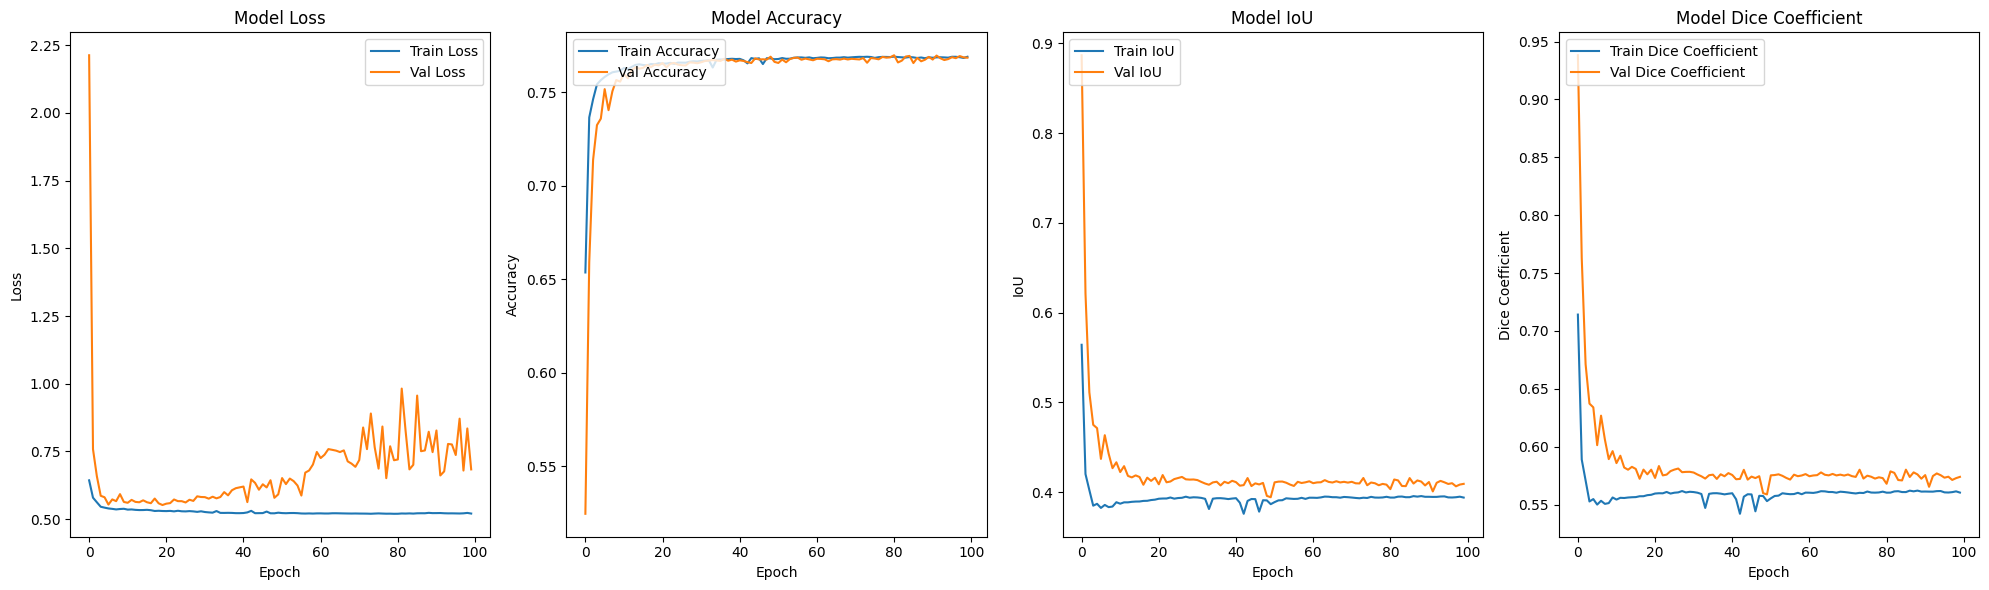

In [13]:
def plot_performance(history):
    # Plot training & validation loss values
    plt.figure(figsize=(20, 6))

    # Plot loss
    plt.subplot(1, 4, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

    # Plot accuracy
    plt.subplot(1, 4, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper left')

    # Plot IoU
    plt.subplot(1, 4, 3)
    plt.plot(history.history['iou_metric'], label='Train IoU')
    plt.plot(history.history['val_iou_metric'], label='Val IoU')
    plt.title('Model IoU')
    plt.xlabel('Epoch')
    plt.ylabel('IoU')
    plt.legend(loc='upper left')

    # Plot Dice coefficient
    plt.subplot(1, 4, 4)
    plt.plot(history.history['dice_coefficient'], label='Train Dice Coefficient')
    plt.plot(history.history['val_dice_coefficient'], label='Val Dice Coefficient')
    plt.title('Model Dice Coefficient')
    plt.xlabel('Epoch')
    plt.ylabel('Dice Coefficient')
    plt.legend(loc='upper left')

    plt.tight_layout()
    plt.show()

# Call the function with the history object
plot_performance(history)